In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# HIDDEN
tips = sns.load_dataset('tips')

In [5]:
# HIDDEN
def minimize(loss_fn, grad_loss_fn, x_vals, y_vals,
             alpha=0.0005, progress=True):
    '''
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta once the loss changes less than 0.0001 between iterations.
    '''
    theta = np.array([0., 0.])
    loss = loss_fn(theta, x_vals, y_vals)
    while True:
        if progress:
            print(f'theta: {theta} | loss: {loss}')
        gradient = grad_loss_fn(theta, x_vals, y_vals)
        new_theta = theta - alpha * gradient
        new_loss = loss_fn(new_theta, x_vals, y_vals)
        
        if abs(new_loss - loss) < 0.0001:
            return new_theta
        
        theta = new_theta
        loss = new_loss

## Fitting a Linear Model Using Gradient Descent

We want to fit a linear model that predicts the tip amount based on the total bill of the table:

$$
f_\boldsymbol\theta (x) = \theta_1 x + \theta_0
$$

In order to optimize $ \theta_1 $ and $ \theta_0 $, we need to first choose a loss function. We will choose the mean squared error loss function:

$$
\begin{aligned}
L(\boldsymbol\theta, \textbf{x}, \textbf{y})
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))^2\\
\end{aligned}
$$

Note that we have modified our loss function to reflect the addition of an explanatory variable in our new model. Now, $ \textbf{x} $ is a vector containing the individual total bills, $ \textbf{y} $ is a vector containing the individual tip amounts, and $ \boldsymbol\theta $ is a vector: $ \boldsymbol\theta = [ \theta_1, \theta_0 ] $.

Using a linear model with the squared error also goes by the name of least-squares linear regression. We can use gradient descent to find the $ \boldsymbol\theta $ that minimizes the loss.

**An Aside on Using Correlation**

If you have seen least-squares linear regression before, you may recognize that we can compute the correlation coefficient and use it to determine $ \theta_1 $ and $ \theta_0 $. This is simpler and faster to compute than using gradient descent for this specific problem, similar to how computing the mean was simpler than using gradient descent to fit a constant model. We will use gradient descent anyway because it is a general-purpose method of loss minimization that still works when we later introduce models that do not have analytic solutions. In fact, in many real-world scenarios, we will use gradient descent even when an analytic solution exists because computing the analytic solution can take longer than gradient descent, especially on large datasets.

## Derivative of the MSE Loss

In order to use gradient descent, we have to compute the derivative of the MSE loss with respect to $ \boldsymbol\theta $. Now that $ \boldsymbol\theta $ is a vector of length 2 instead of a scalar, $ \nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{x}, \textbf{y}) $ will also be a vector of length 2.

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\boldsymbol\theta, \textbf{x}, \textbf{y})
&= \nabla_{\boldsymbol\theta} \left[ \frac{1}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))^2 \right] \\
&= \frac{1}{n} \sum_{i = 1}^{n}2 (y_i - f_\boldsymbol\theta (x_i))(- \nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i))\\
&= -\frac{2}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i))\\
\end{aligned}
$$

We know:

$$
f_\boldsymbol\theta (x) = \theta_1 x + \theta_0
$$

We now need to compute $ \nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i) $ which is a length 2 vector.

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i)
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} f_\boldsymbol\theta (x_i)\\
     \frac{\partial}{\partial \theta_1} f_\boldsymbol\theta (x_i)
   \end{bmatrix} \\
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} [\theta_1 x_i + \theta_0]\\
     \frac{\partial}{\partial \theta_1} [\theta_1 x_i + \theta_0]
   \end{bmatrix} \\
&= \begin{bmatrix}
     1 \\
     x_i
   \end{bmatrix} \\
\end{aligned}
$$

Finally, we plug back into our formula above to get

$$
\begin{aligned}
\nabla_{\boldsymbol\theta} L(\theta, \textbf{x}, \textbf{y})
&= -\frac{2}{n} \sum_{i = 1}^{n}(y_i - f_\boldsymbol\theta (x_i))(\nabla_{\boldsymbol\theta} f_\boldsymbol\theta (x_i))\\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - f_\boldsymbol\theta (x_i)) \begin{bmatrix} 1 \\ x_i \end{bmatrix} \\
&= -\frac{2}{n} \sum_{i = 1}^{n} \begin{bmatrix}
    (y_i - f_\boldsymbol\theta (x_i)) \\
    (y_i - f_\boldsymbol\theta (x_i)) x_i
    \end{bmatrix} \\
\end{aligned}
$$

This is a length 2 vector since $ (y_i - f_\boldsymbol\theta (x_i)) $ is scalar.

## Running Gradient Descent

Now, let's fit a linear model on the tips dataset to predict the tip amount from the total table bill.

First, we define a Python function to compute the loss:

In [6]:
def simple_linear_model(thetas, x_vals):
    '''Returns predictions by a linear model on x_vals.'''
    return thetas[0] + thetas[1] * x_vals

def mse_loss(thetas, x_vals, y_vals):
    return np.mean((y_vals - simple_linear_model(thetas, x_vals)) ** 2)

Then, we define a function to compute the gradient of the loss:

In [7]:
def grad_mse_loss(thetas, x_vals, y_vals):
    n = len(x_vals)
    grad_0 = y_vals - simple_linear_model(thetas, x_vals)
    grad_1 = (y_vals - simple_linear_model(thetas, x_vals)) * x_vals
    return -2 / n * np.array([np.sum(grad_0), np.sum(grad_1)])

In [8]:
# HIDDEN
thetas = np.array([1, 1])
x_vals = np.array([3, 4])
y_vals = np.array([4, 5])
assert np.allclose(grad_mse_loss(thetas, x_vals, y_vals), [0, 0])

We'll use the previously defined `minimize` function that runs gradient descent, accounting for our new explanatory variable. It has the function signature (body omitted):

```python
minimize(loss_fn, grad_loss_fn, x_vals, y_vals)
```

Finally, we run gradient descent!

In [9]:
%%time

thetas = minimize(mse_loss, grad_mse_loss, tips['total_bill'], tips['tip'])

theta: [0. 0.] | cost: 10.896283606557377
theta: [0.   0.07] | cost: 3.8937622006094705
theta: [0.  0.1] | cost: 1.9359443267168215
theta: [0.01 0.12] | cost: 1.388538448286097
theta: [0.01 0.13] | cost: 1.235459416905535
theta: [0.01 0.14] | cost: 1.1926273731479433
theta: [0.01 0.14] | cost: 1.1806184944517062
theta: [0.01 0.14] | cost: 1.177227251696266
theta: [0.01 0.14] | cost: 1.1762453624313751
theta: [0.01 0.14] | cost: 1.1759370980989148
theta: [0.01 0.14] | cost: 1.175817178966766
CPU times: user 272 ms, sys: 67.3 ms, total: 339 ms
Wall time: 792 ms


We can see that gradient descent converges to the theta values of $\hat\theta_0 = 0.01$ and $\hat\theta_1 = 0.14$. Our linear model is:

$$y = 0.14x + 0.01$$


We can use our estimated thetas to make and plot our predictions alongside the original data points.

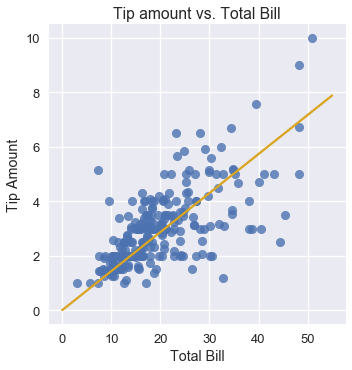

In [10]:
# HIDDEN
x_vals = np.array([0, 55])
sns.lmplot(x='total_bill', y='tip', data=tips, fit_reg=False)
plt.plot(x_vals, simple_linear_model(thetas, x_vals), c='goldenrod')
plt.title('Tip amount vs. Total Bill')
plt.xlabel('Total Bill')
plt.ylabel('Tip Amount');

We can see that if a table's bill is $\$10$, our model will predict that the waiter gets around $\$1.50$ in tip. Similarly, if a table's bill is $\$40$, our model will predict a tip of around $\$6.00$.